<center>
<img src="https://habrastorage.org/webt/ia/m9/zk/iam9zkyzqebnf_okxipihkgjwnw.jpeg">
     
## <center>  [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 

#### <center> Author: [Yury Kashnitsky](https://yorko.github.io) (@yorko) 

# <center>Assignment #2. Fall 2019. Solution
## <center> Part 2. Gradient boosting

Beating benchmarks in [this competition](https://www.kaggle.com/c/flight-delays-fall-2018/overview).

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from catboost import CatBoostClassifier

**Read the data**

In [2]:
PATH_TO_DATA = Path('../input/flight-delays-fall-2018/')

In [3]:
train_df = pd.read_csv(PATH_TO_DATA / 'flight_delays_train.csv')

In [4]:
train_df.shape

(100000, 9)

In [5]:
train_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [6]:
test_df = pd.read_csv(PATH_TO_DATA / 'flight_delays_test.csv')

In [7]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance
0,c-7,c-25,c-3,615,YV,MRY,PHX,598
1,c-4,c-17,c-2,739,WN,LAS,HOU,1235
2,c-12,c-2,c-7,651,MQ,GSP,ORD,577
3,c-3,c-25,c-7,1614,WN,BWI,MHT,377
4,c-6,c-6,c-3,1505,UA,ORD,STL,258


**Create features**

Mostly from [this Kernel](https://www.kaggle.com/rohitgr/lgbm-bayesianoptimization-eda)

In [8]:
# flight
train_df['flight'] = train_df['Origin'] + '-->' + train_df['Dest']
test_df['flight'] = test_df['Origin'] + '-->' + test_df['Dest']

# Hour and minute
train_df['hour'] = train_df['DepTime'] // 100
train_df.loc[train_df['hour'] == 24, 'hour'] = 0
train_df.loc[train_df['hour'] == 25, 'hour'] = 1
train_df['minute'] = train_df['DepTime'] % 100

test_df['hour'] = test_df['DepTime'] // 100
test_df.loc[test_df['hour'] == 24, 'hour'] = 0
test_df.loc[test_df['hour'] == 25, 'hour'] = 1
test_df['minute'] = test_df['DepTime'] % 100

# Season
train_df['summer'] = (train_df['Month'].isin([6, 7, 8])).astype(np.int32)
train_df['autumn'] = (train_df['Month'].isin([9, 10, 11])).astype(np.int32)
train_df['winter'] = (train_df['Month'].isin([12, 1, 2])).astype(np.int32)
train_df['spring'] = (train_df['Month'].isin([3, 4, 5])).astype(np.int32)

test_df['summer'] = (test_df['Month'].isin([6, 7, 8])).astype(np.int32)
test_df['autumn'] = (test_df['Month'].isin([9, 10, 11])).astype(np.int32)
test_df['winter'] = (test_df['Month'].isin([12, 1, 2])).astype(np.int32)
test_df['spring'] = (test_df['Month'].isin([3, 4, 5])).astype(np.int32)

# Daytime
train_df['daytime'] = pd.cut(train_df['hour'], bins=[0, 6, 12, 18, 23], include_lowest=True)
test_df['daytime'] = pd.cut(test_df['hour'], bins=[0, 6, 12, 18, 23], include_lowest=True)

# Extract the labels
train_y = train_df.pop('dep_delayed_15min')
train_y = train_y.map({'N': 0, 'Y': 1})

# Concatenate for preprocessing
train_split = train_df.shape[0]
full_df = pd.concat((train_df, test_df))
full_df['Distance'] = np.log(full_df['Distance'])

# String to numerical
for col in ['Month', 'DayofMonth', 'DayOfWeek']:
    full_df[col] = full_df[col].apply(lambda x: x.split('-')[1]).astype(np.int32) - 1

# Label Encoding
for col in ['Origin', 'Dest', 'UniqueCarrier', 'daytime', 'flight']:
    full_df[col] = pd.factorize(full_df[col])[0]

# Categorical columns
cat_cols = ['Month', 'DayofMonth', 'DayOfWeek', 'Origin', 'Dest', 'UniqueCarrier', 
            'hour', 'summer', 'autumn', 'winter', 'spring', 'daytime', 'flight']

# Converting categorical columns to type 'category' as required by LGBM
for c in cat_cols:
    full_df[c] = full_df[c].astype('category')

# Split into train and test
train_df, test_df = full_df.iloc[:train_split], full_df.iloc[train_split:]
train_df.shape, train_y.shape, test_df.shape

((100000, 16), (100000,), (100000, 16))

**Remember the indexes of categorical features**

In [9]:
train_df.dtypes

Month            category
DayofMonth       category
DayOfWeek        category
DepTime             int64
UniqueCarrier    category
Origin           category
Dest             category
Distance          float64
flight           category
hour             category
minute              int64
summer           category
autumn           category
winter           category
spring           category
daytime          category
dtype: object

In [10]:
categ_feat_idx = np.where(train_df.dtypes == 'category')[0]
categ_feat_idx

array([ 0,  1,  2,  4,  5,  6,  8,  9, 11, 12, 13, 14, 15], dtype=int64)

In [11]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)

In [13]:
former_feats = ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier', 
                'Origin', 'Dest', 'Distance', 'flight']
new_feats = ['hour', 'minute', 'summer', 'autumn', 'winter', 'spring', 'daytime']

In [14]:
ctb = CatBoostClassifier(task_type='GPU', random_seed=17, silent=True)

In [15]:
%%time
features_to_use = former_feats[:]
initial_cv_scores = cross_val_score(ctb, train_df[features_to_use].values, train_y, cv=skf, scoring='roc_auc', 
                fit_params={'cat_features': np.where(train_df[features_to_use].dtypes == 'category')[0]})
initial_cv_scores, initial_cv_scores.mean()

Wall time: 8min 39s


**Now we are performing cross-validation addigng features one by one**

In [16]:
%%time
cv_scores = []

features_to_use = former_feats[:]

for new_feat in tqdm(new_feats):
    print(f'adding feature {new_feat}')
    
    features_to_use += [new_feat]
    print(f'performing CV with features: {features_to_use}')

    current_cv_scores = cross_val_score(ctb, train_df[features_to_use].values, train_y, cv=skf, scoring='roc_auc', 
                fit_params={'cat_features': np.where(train_df[features_to_use].dtypes == 'category')[0]})
    print('5-fold CV is : {} +/- {}'.format(current_cv_scores.mean().round(4), 
                                            current_cv_scores.std().round(4)))
    cv_scores.append(current_cv_scores)
    

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

adding feature hour
performing CV with features: ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'flight', 'hour']
5-fold CV is : 0.7898 +/- 0.0038


 14%|███████████▊                                                                       | 1/7 [06:37<39:47, 397.86s/it]

adding feature minute
performing CV with features: ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'flight', 'hour', 'minute']
5-fold CV is : 0.822 +/- 0.0071


 29%|███████████████████████▋                                                           | 2/7 [13:13<33:06, 397.29s/it]

adding feature summer
performing CV with features: ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'flight', 'hour', 'minute', 'summer']
5-fold CV is : 0.8233 +/- 0.0055


 43%|███████████████████████████████████▌                                               | 3/7 [19:40<26:15, 394.00s/it]

adding feature autumn
performing CV with features: ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'flight', 'hour', 'minute', 'summer', 'autumn']
5-fold CV is : 0.8231 +/- 0.0061


 57%|███████████████████████████████████████████████▍                                   | 4/7 [25:55<19:25, 388.53s/it]

adding feature winter
performing CV with features: ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'flight', 'hour', 'minute', 'summer', 'autumn', 'winter']
5-fold CV is : 0.8238 +/- 0.0067


 71%|███████████████████████████████████████████████████████████▎                       | 5/7 [32:16<12:52, 386.24s/it]

adding feature spring
performing CV with features: ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'flight', 'hour', 'minute', 'summer', 'autumn', 'winter', 'spring']
5-fold CV is : 0.8235 +/- 0.0061


 86%|███████████████████████████████████████████████████████████████████████▏           | 6/7 [38:29<06:22, 382.06s/it]

adding feature daytime
performing CV with features: ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'flight', 'hour', 'minute', 'summer', 'autumn', 'winter', 'spring', 'daytime']
5-fold CV is : 0.8236 +/- 0.0056


100%|███████████████████████████████████████████████████████████████████████████████████| 7/7 [45:01<00:00, 385.20s/it]


Wall time: 45min 1s


In [17]:
from matplotlib import pyplot as plt
%config InlineBackend.figure_format='retina'

In [18]:
mean_cv_scores = np.array(cv_scores).mean(axis=1)
mean_cv_scores_minus_std = np.array(cv_scores).mean(axis=1) - np.array(cv_scores).std(axis=1)
mean_cv_scores_plus_std = np.array(cv_scores).mean(axis=1) + np.array(cv_scores).std(axis=1)

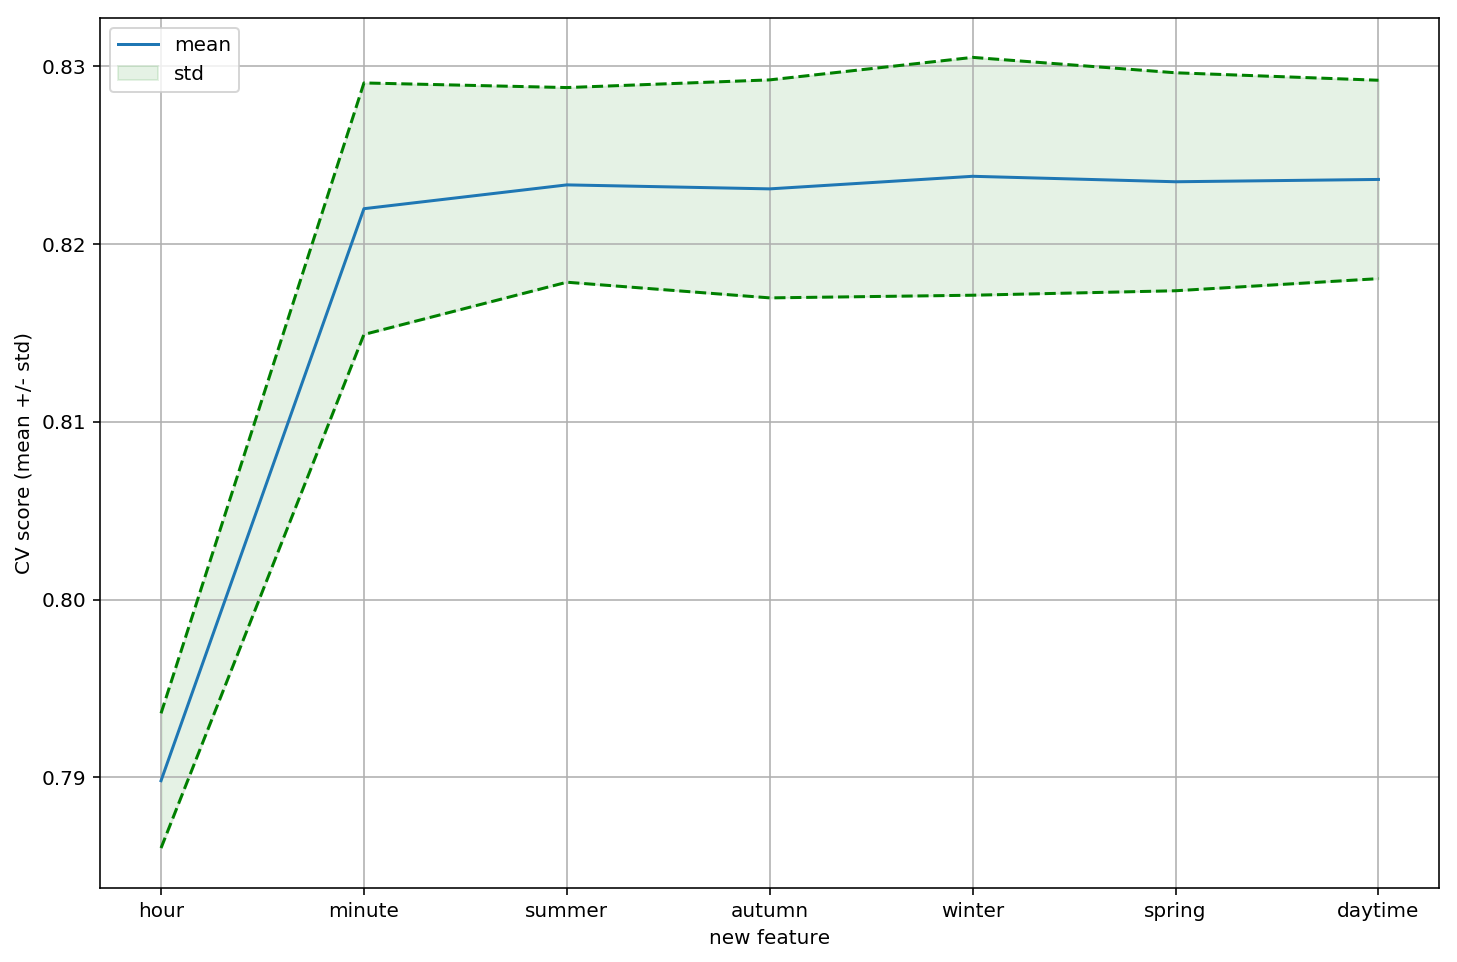

In [19]:
plt.figure(figsize=(12, 8))
plt.plot(new_feats, mean_cv_scores, label='mean');
plt.plot(new_feats, mean_cv_scores_minus_std, c='green', linestyle='dashed');
plt.plot(new_feats, mean_cv_scores_plus_std, c='green', linestyle='dashed');
plt.fill_between(new_feats, mean_cv_scores_minus_std, mean_cv_scores_plus_std,
                 color='green', alpha=.1, label='std')
plt.xlabel('new feature')
plt.ylabel('CV score (mean +/- std)')
plt.grid(True)
plt.legend();

**Now test predictions, again adding features one by one to former 9 ones**

In [20]:
sample_sub = pd.read_csv(PATH_TO_DATA / 'sample_submission.csv',
                         index_col='id')

In [21]:
%%time
features_to_use = former_feats[:]

for i, new_feat in tqdm(enumerate(new_feats)):
    print(f'adding feature {new_feat}')
    
    features_to_use += [new_feat]
    
    print(f'Training with features: {features_to_use}')
    
    cat_feat_idx = np.where(train_df[features_to_use].dtypes == 'category')[0]
    
    ctb.fit(train_df[features_to_use].values, train_y,cat_features=cat_feat_idx)
    ctb_test_pred = ctb.predict_proba(test_df[features_to_use].values)[:, 1]
    
    sample_sub['dep_delayed_15min'] = ctb_test_pred
    sub_file_name = f'ctb_pred_old_feats_and_{i+1}_new_ones.csv'
    sample_sub.to_csv(sub_file_name)
    
    print(f'Wrote predictions to {sub_file_name}')

0it [00:00, ?it/s]

adding feature hour
Training with features: ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'flight', 'hour']
Wrote predictions to ctb_pred_old_feats_and_1_new_ones.csv


1it [01:21, 81.93s/it]

adding feature minute
Training with features: ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'flight', 'hour', 'minute']
Wrote predictions to ctb_pred_old_feats_and_2_new_ones.csv


2it [02:45, 82.51s/it]

adding feature summer
Training with features: ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'flight', 'hour', 'minute', 'summer']
Wrote predictions to ctb_pred_old_feats_and_3_new_ones.csv


3it [04:10, 83.04s/it]

adding feature autumn
Training with features: ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'flight', 'hour', 'minute', 'summer', 'autumn']
Wrote predictions to ctb_pred_old_feats_and_4_new_ones.csv


4it [05:35, 83.72s/it]

adding feature winter
Training with features: ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'flight', 'hour', 'minute', 'summer', 'autumn', 'winter']
Wrote predictions to ctb_pred_old_feats_and_5_new_ones.csv


5it [06:59, 83.83s/it]

adding feature spring
Training with features: ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'flight', 'hour', 'minute', 'summer', 'autumn', 'winter', 'spring']
Wrote predictions to ctb_pred_old_feats_and_6_new_ones.csv


6it [08:24, 84.05s/it]

adding feature daytime
Training with features: ['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'UniqueCarrier', 'Origin', 'Dest', 'Distance', 'flight', 'hour', 'minute', 'summer', 'autumn', 'winter', 'spring', 'daytime']
Wrote predictions to ctb_pred_old_feats_and_7_new_ones.csv


7it [09:52, 85.52s/it]


Wall time: 9min 52s


**Analyzing CV & LB scores**

|          | Old feature set | +hour   | +minute | +summer | +autumn | +winter | +spring | +daytime |
|----------|-----------------|---------|---------|---------|---------|---------|---------|----------|
| Mean CV score | 0.765         | 0.789  | 0.812  | 0.821  | 0.82  | 0.822   | 0.821  | 0.821   |
| LB score | 0.73496         | 0.74505 | 0.76007 | 0.76136 | 0.76200 | 0.76014 | 0.76093 | 0.76082  |





CV scores have standard deviation from 0.001 to 0.003 (see results above), i.e mean CV scores can be reported with precision up to 3 decimals. Also, results might differ a bit from run to run. 

In [22]:
result_df = pd.DataFrame({'mean_cv_score': [0.765, 0.789, 0.82, 0.821, 0.82, 0.822, 0.821, 0.821],
                          'lb_score':      [0.73496, 0.74505, 0.76007, 0.76136, 0.76200, 0.76014, 0.76093, 0.76082 ]})

In [23]:
result_df.corr()

,mean_cv_score,lb_score
mean_cv_score,1.000000,0.996372
lb_score,0.996372,1.000000


We see an almost perfect correlation between cross-validation and leaderboard scores. That means that cross-validation is set-up fine.